In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7704190759519636659
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2254123828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11007571688161032467
physical_device_desc: "device: 0, name: GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
import os
import subprocess
# 파이썬 환경 구축 후 라이브러리 버전 맞춰 설치
packages_to_install = [
    "transformers==4.30.2",
    "torch==2.1.0",
    "soynlp==0.0.493",
    "requests==2.31.0",
    "tensorflow==2.10.0",
    "accelerate==0.20.1",
    "kss==4.5.4",
    "matplotlib==3.7.3",
    "wordcloud==1.9.2",
    "JPype1==1.4.1",
    "rhinoMorph==4.0.1.12",
    "kiwipiepy==0.16.1",
    "Konlpy==0.6.0",
    "nltk==3.8.1",
    "seaborn==0.13.0"
]

for package in packages_to_install:
    os.system(f"pip install {package}")

# pip 업그레이드
os.system("python -m pip install --upgrade pip")

# 파이썬 라이브러리 버전 전체 확인
os.system("pip freeze")

# 파이썬 라이브러리 버전 하나씩 확인
packages_to_show = [
    "transformers",
    "torch",
    "soynlp",
    "requests",
    "tensorflow",
    "accelerate",
    "kss",
    "matplotlib",
    "wordcloud",
    "JPype1",
    "rhinoMorph",
    "kiwipiepy",
    "Konlpy",
    "nltk",
    "seaborn"
]

for package in packages_to_show:
    os.system(f"pip show {package}")


# git에서 라이브러리 복제
os.system("git clone https://github.com/ZIZUN/korean-malicious-comments-dataset.git")
os.system("bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)")

subprocess.call("pip install git+https://github.com/haven-jeon/PyKoSpacing.git", shell=True)
print("라이브러리 설치가 완료되었습니다.")


라이브러리 설치가 완료되었습니다.


In [3]:
import re
import torch
import pandas as pd

device=torch.device('cuda:0'if torch.cuda.is_available()else 'cpu')
print("device =",device)

device = cpu


In [4]:
df = pd.read_excel(r"C:\Users\GJAISCHOOL\Desktop\X_filter\Algorithm\dataset\sample_data(100).xlsx")

df.head()

Sentence  label
0                                    좌배 까는건 ㅇㅂ      1
1                 집에 롱 패딩만 세 개다. 10년 더 입어야지 ㅋㅋ      0
2  개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아      1
3                                  세탁이라고 봐도 된다      0
4                            애새끼가 초딩도 아니고 ㅋㅋㅋㅋ      1

In [5]:
null_idx = df[df.label.isnull()].index                             # 해당 index에 null 값 확인
df.loc[null_idx, "Sentence"]                                       # null 값이 존재한 인덱스의 content 값 불러오기

# lable은 content의 가장 끝 문장열로 설정
df.loc[null_idx, "label"] = df.loc[null_idx, "Sentence"].apply(lambda x: x[-1])

# content는 "\t" 앞부분까지의 문자열로 설정
df.loc[null_idx, "Sentence"] = df.loc[null_idx, "Sentence"].apply(lambda x: x[-2])

In [6]:
import sys
sys.path.append("../Morphological_Analyzer/")

In [7]:
# from kiwipiepy import Kiwi
from kiwi import *

kiwi_pre_train = df.sample(frac=0.8, random_state=42)                     # train(80%), test(20%) 셋 구분 
kiwi_pre_test = df.drop(kiwi_pre_train.index)                             # 랜덤으로 샘플링(랜덤으로 숫자 배치)

# 데이터셋 갯수 확인
print('중복 제거 전 학습 데이터셋 : {}'.format(len(kiwi_pre_train)))
print('중복 제거 전 테스트 데이터셋 : {}'.format(len(kiwi_pre_test)))

# 중복 데이터 제거
kiwi_pre_train.drop_duplicates(subset=["Sentence"], inplace=True)
kiwi_pre_test.drop_duplicates(subset=["Sentence"], inplace=True)

# 형태소 분석 적용
train_morp = list(kiwi.tokenize(kiwi_pre_train['Sentence'].tolist(), normalize_coda=True))
test_morp = list(kiwi.tokenize(kiwi_pre_test['Sentence'].tolist(), normalize_coda=True))

train_data = [train_morp, kiwi_pre_train['label']]
test_data = [test_morp, kiwi_pre_test['label']]


# 데이터셋 갯수 확인
print('중복 제거 후 학습 데이터셋 : {}'.format(len(train_data[0])))
print('중복 제거 후 테스트 데이터셋 : {}'.format(len(test_data[0])))

중복 제거 전 학습 데이터셋 : 80
중복 제거 전 테스트 데이터셋 : 20
중복 제거 후 학습 데이터셋 : 80
중복 제거 후 테스트 데이터셋 : 20


In [8]:
# 각 문장에서 최대 토큰 수 계산
max_tokens = max(len(sentence) for sentence in train_data[0])

In [9]:
# DataFrame 생성
train_df = pd.DataFrame(index=range(len(train_data[0])), columns=range(max_tokens + 1))

# 각 문장에 대해 반복하면서 DataFrame 생성
for i, sentence in enumerate(train_data[0]):
    # DataFrame에 토큰 형태 추가
    for j, token in enumerate(sentence):
        train_df.loc[i, j] = token.form

    # 마지막 열에 'label' 값 추가
    train_df.loc[i, max_tokens] = train_data[1].iloc[i]

# NaN 값을 빈 문자열로 대체
train_df = train_df.fillna('')

# 결과적인 DataFrame 출력
print(train_df)

    0     1   2    3   4    5    6   7    8    9    ... 119 120 121 122 123  \
0    새로     오   면    다  그렇    게    하   ᆷ  열심히    하  ...                       
1   오마쥬     가   뭐    이  ᆫ지    ᆫ    알   ᆷ    ?       ...                       
2     아    그런   거    이   야    ?  ㅋㅋㅋ                ...                       
3    용접    협회  무시    하   지    말   아라   .   저기   현장  ...                       
4    시발    정작   지    네   들   자식    은   몸    쓰    는  ...                       
..  ...   ...  ..  ...  ..  ...  ...  ..  ...  ...  ...  ..  ..  ..  ..  ..   
75  용팔이                                             ...                       
76   대구    경북  당선   조건   :  매국노                     ...                       
77   면도     뭐   ᆫ  스머프  모자    쓰    고   오    앗    네  ...                       
78   여자     들   물    뽕  처먹    여   강간   하    고  동영상  ...                       
79  그래서  씨발롬아  PC    가  나쁘   다는    거   이    야    좋  ...                       

   124 125 126 127 128  
0                    0  
1

In [10]:

# DataFrame 생성
test_df = pd.DataFrame(index=range(len(test_data[0])), columns=range(max_tokens + 1))  # Add one more column for 'label'

# 각 문장에 대해 반복하면서 DataFrame 생성# 각 문장에서 최대 토큰 수 계산
# max_tokens = max(len(sentence) for sentence in test_data[0])
for i, sentence in enumerate(test_data[0]):
    # DataFrame에 토큰 형태 추가
    for j, token in enumerate(sentence):
        test_df.loc[i, j] = token.form

    # 마지막 열에 'label' 값 추가
    test_df.loc[i, max_tokens] = test_data[1].iloc[i]  # Use .iloc[i] to access the value at index i

# NaN 값을 빈 문자열로 대체
test_df = test_df.fillna('')

# 결과적인 DataFrame 출력
print(test_df) 

     0      1    2     3     4    5         6   7   8    9    ... 119 120 121  \
0      집      에    롱    패딩     만    세         개   이   다    .  ...               
1    개소리      야    니     가   빨갱이    를        옹호   하   고  드루킹  ...               
2    박근혜      안    빨    는데    보수   통합         3  원칙  인정    하  ...               
3      열     사발  들이키    어도    아깝    지         않   음           ...               
4   정신병자     천국    이    구나                                    ...               
5      나      ᆫ  사이트    마다   아이디    /        비번   다  다르    고  ...               
6     군대     에서   여군     이    필요    하        ᆫ가               ...               
7     호주     에서    는    남자     들    이        동물  보다  못하    ᆫ  ...               
8     꼴리      지    는     않     고   그냥        존나  귀엽   다       ...               
9     그냥    선거철    에     지   지지자   결집        시키   는   거    이  ...               
10    미치      었    나    진짜    시발                              ...               
11    ㄹㅇ     시위   진압  ㅆㅅㅌㅊ  

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from konlpy.tag import Okt
import nltk

okt = Okt()

# 불용어(stopwords) 리스트를 직접 만들어 사용하거나, 외부에서 가져와 사용합니다.
stop_words = set(['는', '은', '이', '가', '을', '를','그리고','그래서','또한','그러하니','그러나','그리하여','그리하여금','그러한','그러므로',''])  # 사용자 정의 불용어 리스트 예시

# 불용어(stopwords) 리스트에 사용자 정의 불용어를 추가합니다.
# stop_words = set(stopwords.words('english') + custom_stopwords)

for column_index in train_df.columns:
    for index, value in enumerate(train_df[column_index]):
        if isinstance(value, str):  # 문자열인 경우에만 토큰화 수행
            word_tokens = word_tokenize(value)
            # 불용어 제거
            train_df[column_index][index] = ' '.join([word for word in word_tokens if not word in stop_words])
            
        else:
            pass

train_df['merged_sentences'] = train_df.apply(lambda row: ' '.join([str(token) for token in row if token is not None]), axis=1)
print(train_df['merged_sentences'])

C:\Users\GJAISCHOOL\AppData\Local\Temp\ipykernel_28588\2567306536.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[column_index][index] = ' '.join([word for word in word_tokens if not word in stop_words])
C:\Users\GJAISCHOOL\AppData\Local\Temp\ipykernel_28588\2567306536.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[column_index][index] = ' '.join([word for word in word_tokens if not word in stop_words])
C:\Users\GJAISCHOOL\AppData\Local\Temp\ipykernel_28588\2567306536.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

0     새로 오 면 다 그렇 게 하 ᆷ 열심히 하  티  팍팍 내 고 뭐 바꾸 고 뭐 하 ...
1     오마쥬  뭐  ᆫ지 ᆫ 알 ᆷ ?                            ...
2     아 그런 거  야 ? ㅋㅋㅋ                               ...
3     용접 협회 무시 하 지 말 아라 . 저기 현장 고수 및 용접 에 관하 ᆫ 전문 지식...
4     시발 정작 지 네 들 자식  몸 쓰  일 안 시키 ᆯ 거  면서 개지랄떠네 ㅋㅋㅋ ...
                            ...                        
75    용팔이                                           ...
76    대구 경북 당선 조건 : 매국노                             ...
77    면도 뭐 ᆫ 스머프 모자 쓰 고 오 앗 네                       ...
78    여자 들 물 뽕 처먹 여 강간 하 고 동영상 찍  것  죄  아니 었 구나 ㅋㅋ 버...
79     씨발롬아 PC  나쁘 다는 거  야 좋 다는 거  야 ?              ...
Name: merged_sentences, Length: 80, dtype: object


C:\Users\GJAISCHOOL\AppData\Local\Temp\ipykernel_28588\2567306536.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[column_index][index] = ' '.join([word for word in word_tokens if not word in stop_words])
C:\Users\GJAISCHOOL\AppData\Local\Temp\ipykernel_28588\2567306536.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[column_index][index] = ' '.join([word for word in word_tokens if not word in stop_words])
C:\Users\GJAISCHOOL\AppData\Local\Temp\ipykernel_28588\2567306536.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

In [12]:
for column_index in test_df.columns:
    for index, value in enumerate(test_df[column_index]):
        if isinstance(value, str):  # 문자열인 경우에만 토큰화 수행
            word_tokens = word_tokenize(value)
            # 불용어 제거
            test_df[column_index][index] = ' '.join([word for word in word_tokens if not word in stop_words])
            
        else:
            pass

test_df['merged_sentences'] = test_df.apply(lambda row: ' '.join([str(token) for token in row if token is not None]), axis=1)
print(test_df['merged_sentences'])

C:\Users\GJAISCHOOL\AppData\Local\Temp\ipykernel_28588\2334454352.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[column_index][index] = ' '.join([word for word in word_tokens if not word in stop_words])
C:\Users\GJAISCHOOL\AppData\Local\Temp\ipykernel_28588\2334454352.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[column_index][index] = ' '.join([word for word in word_tokens if not word in stop_words])
C:\Users\GJAISCHOOL\AppData\Local\Temp\ipykernel_28588\2334454352.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

0     집 에 롱 패딩 만 세 개  다 . 10 년 더 입 어야지 ㅋㅋ           ...
1     개소리 야 니  빨갱이  옹호 하 고 드루킹  ㅇㅇ 짓  라고 말 못 하 여서 삐지...
2     박근혜 안 빨 는데 보수 통합 3 원칙 인정 하 ᆷ                  ...
3     열 사발 들이키 어도 아깝 지 않 음                          ...
4     정신병자 천국  구나                                   ...
5     나 ᆫ 사이트 마다 아이디 / 비번 다 다르 고 난이도 높 음 엑셀 파일 에 모든 ...
6     군대 에서 여군  필요 하 ᆫ가                             ...
7     호주 에서  남자 들  동물 보다 못하 ᆫ 존재  라던데 ㅋㅋ            ...
8     꼴리 지  않 고 그냥 존나 귀엽 다                          ...
9     그냥 선거철 에 지 지지자 결집 시키  거  ᆷ 자기 지지 층 에 ᆫ 아시아인  별...
10    미치 었 나 진짜 시발                                  ...
11    ㄹㅇ 시위 진압 ㅆㅅㅌㅊ  었 음                            ...
12    영혼 까지 팔 아도 되 ᆫ다는 놈  ᆯ 거  야                    ...
13    진주  네요 ... 여기 동네 에 잠시 살 았 는데 ... 여기 주차 장난 아니 ᆸ...
14    나 안동 김 씨                                      ...
15    ㅂㄷㅂㄷ ㅋㅋㅋㅋㅋ 중국 욕하니 ㅂㄷㅂㄷ 하죠 ㅋㅋㅋㅋㅋㅋㅋㅋ            ...
16    오이 오이 아부  네                                   ...
17    무게 치  거 에 인생 버리 ᆫ 새끼 들                    

C:\Users\GJAISCHOOL\AppData\Local\Temp\ipykernel_28588\2334454352.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[column_index][index] = ' '.join([word for word in word_tokens if not word in stop_words])
C:\Users\GJAISCHOOL\AppData\Local\Temp\ipykernel_28588\2334454352.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[column_index][index] = ' '.join([word for word in word_tokens if not word in stop_words])
C:\Users\GJAISCHOOL\AppData\Local\Temp\ipykernel_28588\2334454352.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

In [13]:
train_label = train_df[128].values
test_label = test_df[128].values

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 텍스트를 TF-IDF 벡터로 변환합니다.
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['merged_sentences'])
X_test = vectorizer.transform(test_df['merged_sentences'])  # transform만 사용

# 랜덤 포레스트 모델을 생성하고 학습합니다.
rf_model = RandomForestClassifier()
rf_model.fit(X_train, train_label)

# 테스트 데이터에 대한 예측을 수행합니다.
y_pred = rf_model.predict(X_test)

# 정확도를 출력합니다.
accuracy = accuracy_score(test_label, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.60


오차행렬 
 [[12  0]
 [ 8  0]]
Accuracy_score(정확도) : 0.6
Precision(정밀도) :  0.0
Recall(재현율) : 0.0
TNR(0을 맞춘 비율) : 1.0
F1 score : 0.0


c:\Users\GJAISCHOOL\.conda\envs\nv38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


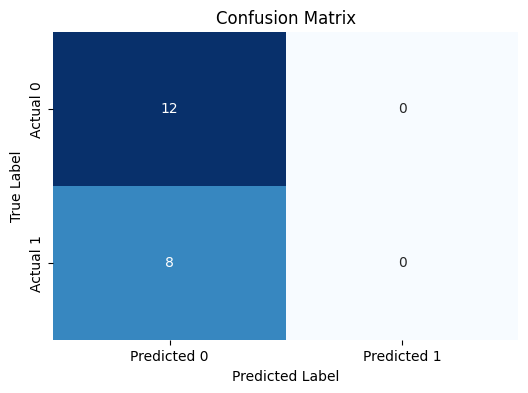

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def print_scores( test_label, y_pred, pred_proba=None):
    # 필요한 모듈 임포트
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, \
        roc_auc_score
    
    # 오차 행렬 계산
    cm = confusion_matrix(test_label, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    # 다양한 성능 지표 출력
    print('오차행렬 \n', cm)
    print('Accuracy_score(정확도) :', accuracy_score(test_label, y_pred))
    print('Precision(정밀도) : ', precision_score(test_label, y_pred))
    print('Recall(재현율) :', recall_score(test_label, y_pred))
    
    # TNR은 True Negative Rate로, 실제 0인 것 중에서 모델이 정확하게 예측한 비율입니다.
    print('TNR(0을 맞춘 비율) :', TN / (TN + FP))
    
    # F1 score 계산
    print('F1 score :', f1_score(test_label, y_pred))
    
    # 예측 확률이 주어진 경우에만 Roc Auc score 출력
    if pred_proba is not None:
        print('Roc Auc score :', roc_auc_score(test_label, pred_proba))

        # 혼동 행렬 그리기
    cm = confusion_matrix(test_label, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


print_scores(test_label,y_pred)

In [26]:
def sentence_predict(sent):
    sentence=True
    new_data_transformed = vectorizer.transform([sent])
    prediction = rf_model.predict(new_data_transformed)
    
    if prediction == 0:
        sentence = True #정상어

    elif prediction == 1:
        sentence = False #비속어
    return sentence, sent

sentence_predict("씨발")

(True, '씨발')

In [17]:
def badword_find(sent):
    result = sent
    badword_df = pd.read_excel(r'C:\Users\GJAISCHOOL\Desktop\X_filter\Algorithm\dataset\word_list.xlsx')
    
    found_bad_word = False  # 입력 문장에 단어가 발견되었는지를 나타내는 플래그
    for idx, row in badword_df.iterrows():
        if row["WORD"] in sent:
            # 'WORD'가 입력 문장에 포함된 경우
            new_word = row["대체어"]
            if not pd.isnull(new_word):
                result = result.replace(row["WORD"], new_word)
                found_bad_word = True
            else:
                result = result.replace(row["WORD"], "*" * len(row["WORD"]))
                found_bad_word = True
    
    if not found_bad_word:
        # result = "@" * len(input_sentence)
        result = "혐오 표현입니다."
    return result

In [18]:
def speak_pre(sent):
    sentence = sentence_predict(sent)
    if sentence[0] == True:
        return sent
    elif sentence[0] == False:
        return badword_find(sent)
    
def speak(sent):
    speak_pre(sent)
    sentence = sentence_predict(sent)
    if sentence[0] == True:
        return sent
    elif sentence[0] == False:
        return badword_find(sent)

In [22]:
# 특수문자 제거
def cleanse(text):
    pattern = re.compile(r'\s+')
    text = re.sub(pattern, ' ', text)
    text = re.sub('[^가-힣ㄱ-ㅎㅏ|a-zA-Z0-9]','', text)
    return text

In [23]:
import re
from soynlp.normalizer import repeat_normalize

def clean_and_repeat_normalize(text):
    cleansed_text = cleanse(text)                                             # 특수문자 제거
    normalized_text = repeat_normalize(cleansed_text, num_repeats=2)          # 중복문자 제거
    input_data = re.sub(r'\d', '', normalized_text)                           #  제거
    # normalized_text = spacing(input_data)                                   # 띄어쓰기 보정 

    return input_data

clean_and_repeat_normalize("아버지가방에들어가신다")

'아버지가방에들어가신다'

In [24]:
import kss

def final_output():
    input_text = clean_and_repeat_normalize(input())
    sentences = kss.split_sentences(input_text)

    sentences_list = []
    for sentence in sentences:
        speak(sentence)
        sentences_list.append(sentence)

    long_test = ' '.join(sentences_list)
    print(long_test)
    return long_test

In [25]:
final_output()

[Kss]: Because there's no supported C++ morpheme analyzer, Kss will take pecab as a backend. :D
For your information, Kss also supports mecab backend.
We recommend you to install mecab or konlpy.tag.Mecab for faster execution of Kss.
Please refer to following web sites for details:
- mecab: https://cleancode-ws.tistory.com/97
- konlpy.tag.Mecab: https://uwgdqo.tistory.com/363



씨발


'씨발'